In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tnrange
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib as mpl
import scipy

In [2]:
comb_pred = np.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms_test.npy").reshape((20,-1))
whole_pred = np.load("/scratch/yjk27/CA1_clust4-60_AP/whole_pred/gru_l20_h40_0.2ms_test.npy").reshape((20,-1))
tcn_pred = np.load("/scratch/yjk27/CA1_clust4-60_AP/tcnmulti_pred/gru_l20_h40_0.2ms_test.npy").reshape((20,-1))
spk = np.load("/scratch/yjk27/CA1_clust4-60_AP/data/spike_train_0.2ms.npy")[980*50000:].reshape((20,-1))

pred_beniag = np.load("/scratch/yjk27/CA1_clust4-60_AP/y_spikes_hat.npy")
spk_beniag = np.load("/scratch/yjk27/CA1_clust4-60_AP/y_spikes_GT.npy")

fpr_comb_pred, tpr_comb_pred, _ = roc_curve(spk.flatten(), comb_pred.flatten())
fpr_whole_pred, tpr_whole_pred, _ = roc_curve(spk.flatten(), whole_pred.flatten())
fpr_tcn_pred, tpr_tcn_pred, _ = roc_curve(spk.flatten(), tcn_pred.flatten())
fpr_beniag, tpr_beniag, _ = roc_curve(spk_beniag.flatten(), pred_beniag.flatten())
beniag_idx = np.where(np.sum(spk_beniag,1) > 0)[0]

rocarea_comb_pred = roc_auc_score(spk.flatten(), comb_pred.flatten())
rocarea_whole_pred = roc_auc_score(spk.flatten(), whole_pred.flatten())
rocarea_tcn_pred = roc_auc_score(spk.flatten(), tcn_pred.flatten())

rocarea_array = np.zeros((20,3))
beniag_array = np.zeros((beniag_idx.shape[0]))

for i in tnrange(20):
    rocarea_array[i,0] = roc_auc_score(spk[i], comb_pred[i])
    rocarea_array[i,1] = roc_auc_score(spk[i], whole_pred[i])
    rocarea_array[i,2] = roc_auc_score(spk[i], tcn_pred[i])
for i in tnrange(beniag_idx.shape[0]):
    beniag_array[i] = roc_auc_score(spk_beniag[beniag_idx[i]], pred_beniag[beniag_idx[i]])

#beniag thresh = 0.1
#comb_pred thresh = 0.04
#whole_pred thresh = 0.04
#tcn_pred thresh = 0.04
spk_idx = np.where(spk.flatten() > 0)[0]
beniag_spk_idx = np.where(spk_beniag.flatten() > 0)[0]
comb_pred_corr = np.zeros((200))
whole_pred_corr = np.zeros((200))
tcn_pred_corr = np.zeros((200))
beniag_corr = np.zeros((40))

comb_pred_thresh = np.zeros((comb_pred.flatten().size))
whole_pred_thresh = np.zeros((whole_pred.flatten().size))
tcn_pred_thresh = np.zeros((whole_pred.flatten().size))
beniag_thresh = np.zeros((spk_beniag.flatten().size))

comb_pos_idx = np.where(comb_pred.flatten() >= 0.04)[0]
whole_pos_idx = np.where(whole_pred.flatten() >= 0.04)[0]
tcn_pos_idx = np.where(tcn_pred.flatten() >= 0.04)[0]
beniag_pos_idx = np.where(pred_beniag.flatten() >= 0.1)[0]

comb_pred_thresh[comb_pos_idx] = 1
whole_pred_thresh[whole_pos_idx] = 1
tcn_pred_thresh[tcn_pos_idx] = 1
beniag_thresh[beniag_pos_idx] = 1

for i in range(spk_idx.size):
    t = spk_idx[i]
    comb_pred_corr += comb_pred_thresh[t-100:t+100]
    whole_pred_corr += whole_pred_thresh[t-100:t+100]
    tcn_pred_corr += tcn_pred_thresh[t-100:t+100]
for i in range(beniag_spk_idx.size):
    t = beniag_spk_idx[i]
    beniag_corr += beniag_thresh[t-20:t+20]

<ipython-input-2-0d5e466356bf>:22: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(20):


  0%|          | 0/20 [00:00<?, ?it/s]

<ipython-input-2-0d5e466356bf>:26: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(beniag_idx.shape[0]):


  0%|          | 0/420 [00:00<?, ?it/s]

In [3]:
#AP True 0.9156042360417361 0.9156042360417361 0.0096387818643847 0.0096387818643847
#Na True 0.8143590159840158 0.8386963383838383 0.06843242335670274 0.06615087825324792
#No Na True 0.34974221611721606 0.6056746031746031 0.0940514647548976 0.11510389858903808
#Comb Pred 0.47738816738816736 0.5966674783549784 0.13561578097444554 0.12230436902117042
#Whole Pred 0.34591172716172713 0.5486351367828324 0.11432601029228029 0.13394760326878388

full_coinc = np.load("/scratch/yjk27/CA1_clust4-60_AP/ap_true/coinc_4ms_15v.npy").reshape(-1,1)
soma_coinc = np.load("/scratch/yjk27/CA1_clust4-60_AP/na_true/coinc_4ms_15v.npy").reshape(-1,1)
nona_coinc = np.load("/scratch/yjk27/CA1_clust4-60_AP/nona_true/coinc_4ms_15v.npy").reshape(-1,1)
comb_pred_coinc = np.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/coinc_4ms_15v.npy").reshape(-1,1)
whole_pred_coinc = np.load("/scratch/yjk27/CA1_clust4-60_AP/whole_pred/coinc_4ms_15v.npy").reshape(-1,1)
coinc_all = np.hstack((full_coinc, soma_coinc, nona_coinc, comb_pred_coinc, whole_pred_coinc))
print(coinc_all.shape)

offset = np.mean(np.load("/scratch/yjk27/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1_set1.npy"))
V_full = np.load("/scratch/yjk27/CA1_clust4-60_AP/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy")[-20:,:50000]
V_comb_pred = np.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/gru_l20_h40_0.2ms_test_V.npy") \
            + np.load("/scratch/yjk27/CA1_clust4-60_AP/comb_pred/V_comb_pred_0.2ms.npy")[-20:].reshape(20,50000) + offset
V_whole_pred = np.load("/scratch/yjk27/CA1_clust4-60_AP/whole_pred/gru_l20_h40_0.2ms_test_V.npy").reshape(20,50000) \
            + np.load("/scratch/yjk27/CA1_clust4-60_AP/whole_pred/V_whole_pred_0.2ms.npy")[-20:].reshape(20,50000) + offset

(20, 5)


<ipython-input-13-cf5e754a7a15>:162: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


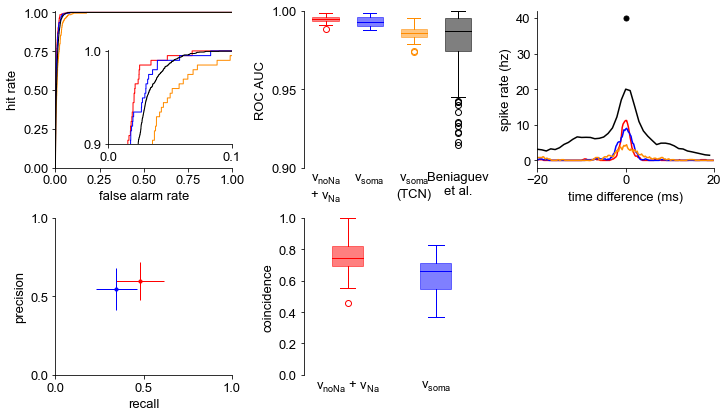

In [13]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = '13'

fig = plt.figure(constrained_layout=True, figsize = (10,8))
gs = fig.add_gridspec(3,3, wspace=0.25, hspace=0.3)
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,0])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[1,1])

color1 = "red"
color2 = "blue"
color3 = "darkorange"
color4 = "black"

colors = [color1, color2, color3, color4]

bp1 = ax1.boxplot(rocarea_array[:,0], positions=[1], widths = 0.6, patch_artist=True)
bp2 = ax1.boxplot(rocarea_array[:,1], positions=[2], widths = 0.6, patch_artist=True)
bp3 = ax1.boxplot(rocarea_array[:,2], positions=[3], widths = 0.6, patch_artist=True)
bp4 = ax1.boxplot(beniag_array, positions=[4], widths = 0.6, patch_artist=True)
bp_list = [bp1, bp2, bp3, bp4]

for i in range(4):
    plt.setp(bp_list[i]['boxes'], facecolor=colors[i])
    plt.setp(bp_list[i]['boxes'], alpha=0.5)
    plt.setp(bp_list[i]["fliers"], markeredgecolor=colors[i])
    plt.setp(bp_list[i]["boxes"], color=colors[i])
    plt.setp(bp_list[i]["medians"], color=colors[i])
    for j in range(2):
        plt.setp(bp_list[i]['whiskers'][j], color=colors[i])
        plt.setp(bp_list[i]['caps'][j], color=colors[i])

ax1.set_xticklabels(["$\mathregular{v_{noNa}}$\n+ $\mathregular{v_{Na}}$",
                     "$\mathregular{v_{soma}}$",
                     "$\mathregular{v_{soma}}$\n(TCN)", "Beniaguev\net al."], rotation=0)
ax1.set_ylabel("ROC AUC")
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["bottom"].set_visible(False)
#ax1.set_ylim(0,1)
ax1.set_ylim(0.9,1)
ax1.set_yticks(np.arange(0.9,1.001,0.05))
ax1.tick_params(axis="x", length=0)
#ax1.set_yticks(np.arange(0,1.01,0.25))
"""
ins = ax1.inset_axes([0.3,0.15,0.7,0.6])
bp1 = ins.boxplot(rocarea_array[:,0], positions=[1], widths = 0.6, patch_artist=True)
bp2 = ins.boxplot(rocarea_array[:,1], positions=[2], widths = 0.6, patch_artist=True)
bp3 = ins.boxplot(rocarea_array[:,2], positions=[3], widths = 0.6, patch_artist=True)
bp4 = ins.boxplot(beniag_array, positions=[4], widths = 0.6, patch_artist=True)
bp_list = [bp1, bp2, bp3, bp4]

for i in range(4):
    plt.setp(bp_list[i]['boxes'], facecolor=colors[i])
    plt.setp(bp_list[i]['boxes'], alpha=0.5)
    plt.setp(bp_list[i]["fliers"], markeredgecolor=colors[i])
    plt.setp(bp_list[i]["boxes"], color=colors[i])
    plt.setp(bp_list[i]["medians"], color=colors[i])
    for j in range(2):
        plt.setp(bp_list[i]['whiskers'][j], color=colors[i])
        plt.setp(bp_list[i]['caps'][j], color=colors[i])

ins.spines["right"].set_visible(False)
ins.spines["top"].set_visible(False)
ins.spines["bottom"].set_visible(False)
ins.set_ylim(0.95,1)
ins.tick_params(axis="x", length=0)
ins.set_xticks([])
ins.set_yticks(np.arange(0.95,1.001,0.05))
"""
ax2.plot(fpr_comb_pred, tpr_comb_pred, linewidth=1, color=color1)
ax2.plot(fpr_whole_pred, tpr_whole_pred, linewidth=1, color=color2)
ax2.plot(fpr_tcn_pred, tpr_tcn_pred, linewidth=1, color=color3)
ax2.plot(fpr_beniag, tpr_beniag, linewidth=1, color=color4)
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.set_ylim(0,1.01)
ax2.set_xlim(0,1)
ax2.set_xlabel("false alarm rate")
ax2.set_ylabel("hit rate")
ax2.set_xticks(np.arange(0,1.01,0.25))
ax2.set_yticks(np.arange(0,1.01,0.25))

ins = ax2.inset_axes([0.3,0.15,0.7,0.6])
ins.plot(fpr_comb_pred, tpr_comb_pred, linewidth=1, color=color1)
ins.plot(fpr_whole_pred, tpr_whole_pred, linewidth=1, color=color2)
ins.plot(fpr_tcn_pred, tpr_tcn_pred, linewidth=1, color=color3)
ins.plot(fpr_beniag, tpr_beniag, linewidth=1, color=color4)
ins.spines["right"].set_visible(False)
ins.spines["top"].set_visible(False)
ins.set_ylim(0.9,1.001)
ins.set_xlim(0,0.1)
ins.set_xticks([0,0.1])
ins.set_yticks([0.9,1])
#ax2.annotate("p = 0.00171", (0.4,0.85))

ax3.plot(np.arange(-20,20,1), beniag_corr/25, color="black")
ax3.plot(np.arange(-20,20,0.2), comb_pred_corr/5, color="red")
ax3.plot(np.arange(-20,20,0.2), whole_pred_corr/5, color="blue")
ax3.plot(np.arange(-20,20,0.2), tcn_pred_corr/5, color="darkorange")
ax3.scatter(0, 40, color="black", s= 25)
ax3.spines["right"].set_visible(False)
ax3.spines["top"].set_visible(False)
#ax3.set_ylim(0.9,1.001)
ax3.set_xlim(0,0.1)
ax3.set_xticks([-20,0,20])
#ax3.set_yticks([0,10,20])
ax3.set_xlabel("time difference (ms)")
ax3.set_ylabel("spike rate (hz)")

############

ax4.scatter(0.47738816738816736, 0.5966674783549784, color="red", s=10)
ax4.scatter(0.34591172716172713, 0.5486351367828324, color="blue", s=10)

ax4.errorbar(0.47738816738816736, 0.5966674783549784, xerr=0.13561578097444554, yerr=0.12230436902117042,
             color="red", linewidth=1)
ax4.errorbar(0.34591172716172713, 0.5486351367828324, xerr=0.11432601029228029, yerr=0.13394760326878388,
             color="blue", linewidth=1)

ax4.spines["right"].set_visible(False)
ax4.spines["top"].set_visible(False)
ax4.set_xlim(0,1)
ax4.set_ylim(0,1)
ax4.set_xticks([0,0.5,1])
ax4.set_yticks([0,0.5,1])
ax4.set_xlabel("recall")
ax4.set_ylabel("precision")


colors = ["red", "blue"]

bp1 = ax5.boxplot(coinc_all[:,3], positions=[1], widths = 0.35, patch_artist=True)
bp2 = ax5.boxplot(coinc_all[:,4], positions=[2], widths = 0.35, patch_artist=True)
bp_list = [bp1, bp2]

for i in range(2):
    plt.setp(bp_list[i]['boxes'], facecolor=colors[i])
    plt.setp(bp_list[i]['boxes'], alpha=0.5)
    plt.setp(bp_list[i]["fliers"], markeredgecolor=colors[i])
    plt.setp(bp_list[i]["boxes"], color=colors[i])
    plt.setp(bp_list[i]["medians"], color=colors[i])
    for j in range(2):
        plt.setp(bp_list[i]['whiskers'][j], color=colors[i])
        plt.setp(bp_list[i]['caps'][j], color=colors[i])
        
ax5.spines["right"].set_visible(False)
ax5.spines["top"].set_visible(False)
ax5.spines["bottom"].set_visible(False)
ax5.tick_params(axis="x", length=0)
ax5.set_ylabel("coincidence")
ax5.set_ylim(0,1)
ax5.set_xticklabels(["$\mathregular{v_{noNa}}$ + $\mathregular{v_{Na}}$",
                    "$\mathregular{v_{soma}}$"])



fig.tight_layout()
#plt.show()
#fig.savefig("/scratch/yjk27/dendrite/fig_ap/fig_ap_raw.pdf", bbox_inches="tight", transparent=True)

In [6]:
from scipy import stats

roc_comb_tcn = stats.ttest_rel(rocarea_array[:,0], rocarea_array[:,1])
roc_comb_whole = stats.ttest_rel(rocarea_array[:,0], rocarea_array[:,2])

precrec_comb_whole = stats.ttest_rel(coinc_all[:,-2], coinc_all[:,-1])

print(roc_comb_whole, roc_comb_tcn)
print(precrec_comb_whole)

Ttest_relResult(statistic=10.350167476734326, pvalue=3.0145457710323562e-09) Ttest_relResult(statistic=3.6480256514113965, pvalue=0.001710809512503397)
Ttest_relResult(statistic=5.119840294427618, pvalue=6.08745477594767e-05)
